# Определение стоимости автомобилей

**Описание проекта**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Примечания:**

- Для оценки качества моделей применяйте метрику RMSE;
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга;
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её;
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра;
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del: del features_train.

**Описание данных**

Данные находятся в файле /datasets/autos.csv.

**Признаки:**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**

- Price — цена (евро)

**План работы.**

1. Загрузить данные и провести предобработку.
1. Выполнить сравнение моделей с использованием различных наборов гиперпараметров.
1. Выбрать лучшую модель по результатам метрики RMSE и времени обучения.
1. Оформить проект и написать выводы.

In [1]:
#!pip3 install prettytable
#!pip install phik==0.10.0

In [2]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from prettytable import PrettyTable
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings('ignore')

## Подготовка данных

Выгрузим данные и изучим их:

In [3]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('/autos.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
185203,2016-03-18 15:06:20,1000,sedan,1999,manual,101,golf,150000,1,petrol,volkswagen,no,2016-03-18 00:00:00,0,65428,2016-03-29 15:46:57
102961,2016-03-22 14:36:23,3750,sedan,2004,manual,90,civic,150000,2,petrol,honda,no,2016-03-22 00:00:00,0,74348,2016-04-06 05:15:39
112652,2016-04-05 16:06:22,9500,small,2009,auto,115,b_klasse,80000,8,petrol,mercedes_benz,no,2016-04-05 00:00:00,0,65934,2016-04-05 16:06:22
49196,2016-03-16 16:54:37,1800,sedan,1995,manual,190,golf,150000,1,petrol,volkswagen,no,2016-03-16 00:00:00,0,27637,2016-03-24 09:15:19
260913,2016-03-29 16:57:46,13000,bus,2010,manual,84,transporter,150000,12,gasoline,volkswagen,no,2016-03-29 00:00:00,0,73770,2016-03-31 10:15:30


In [6]:
df.duplicated().sum()

4

Имеются дубликаты, удалим их:

In [7]:
df.drop_duplicates(inplace=True)  

In [8]:
(df.isna() | df.isnull()).mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105795
RegistrationYear     0.000000
Gearbox              0.055968
Power                0.000000
Model                0.055607
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092828
Brand                0.000000
Repaired             0.200793
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

В столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType` и `Repaired`имеются отсутствующие и/или нулевые значения. Рассмотрим подробнее значения в каждом столбце:

In [9]:
def show_col(df):
    for column in df.columns:
        print('Уникальные значения столбца "{}"'.format(column))
        print(df[column].sort_values().unique())
        print()

In [10]:
show_col(df)

Уникальные значения столбца "DateCrawled"
['2016-03-05 14:06:22' '2016-03-05 14:06:23' '2016-03-05 14:06:24' ...
 '2016-04-07 14:36:55' '2016-04-07 14:36:56' '2016-04-07 14:36:58']

Уникальные значения столбца "Price"
[    0     1     2 ... 19998 19999 20000]

Уникальные значения столбца "VehicleType"
['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]

Уникальные значения столбца "RegistrationYear"
[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 206

Для дальнейшего анализа поменяем стиль заголовков:

In [11]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Пройдемся по столбцам с отсутствующими значениями и постараемся исправить их:

In [12]:
def show_info(col, label):
    display(df[col].describe())
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].boxplot(df[col])
    ax[1].hist(df[col], bins=100)

    ax[0].set_ylabel(label) 
    ax[0].set_title(f'Столбец "{col}"')

    ax[1].set_xlabel(label) 
    ax[1].set_ylabel('Количество') 
    ax[1].set_title(f'Столбец "{col}"')

    plt.show() 

### price

Начнем с целевого признака:

In [13]:
df['price'].value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: price, Length: 3731, dtype: int64

Удалим значения со стоимостью 0 и построим графики:

count    343593.000000
mean       4555.147363
std        4515.076200
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

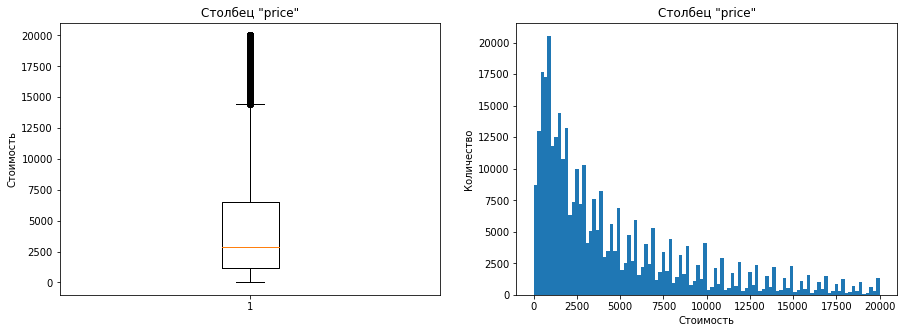

In [14]:
df = df.query('price > 0')
show_info('price', 'Стоимость')

Несмотря на то, что боксплот не показывает выбросы со стороны "левого" уса, но будем честны, за 1 доллар автомобиль на ходу не купить. Для адекватности будем использовать данные от 5% квантиля и до конца "правого" уса.

In [15]:
IQR = df['price'].quantile(.75) - df['price'].quantile(.25)
df['price'].quantile(.05), df['price'].quantile(.75) + IQR * 1.5

(350.0, 14450.0)

In [16]:
df = df.query('350 <= price <= 14450')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309117 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        309117 non-null  object
 1   price               309117 non-null  int64 
 2   vehicle_type        280512 non-null  object
 3   registration_year   309117 non-null  int64 
 4   gearbox             295026 non-null  object
 5   power               309117 non-null  int64 
 6   model               294097 non-null  object
 7   kilometer           309117 non-null  int64 
 8   registration_month  309117 non-null  int64 
 9   fuel_type           284468 non-null  object
 10  brand               309117 non-null  object
 11  repaired            251817 non-null  object
 12  date_created        309117 non-null  object
 13  number_of_pictures  309117 non-null  int64 
 14  postal_code         309117 non-null  int64 
 15  last_seen           309117 non-null  object
dtypes:

count    309117.000000
mean       4020.199818
std        3453.493016
min         350.000000
25%        1299.000000
50%        2800.000000
75%        5900.000000
max       14450.000000
Name: price, dtype: float64

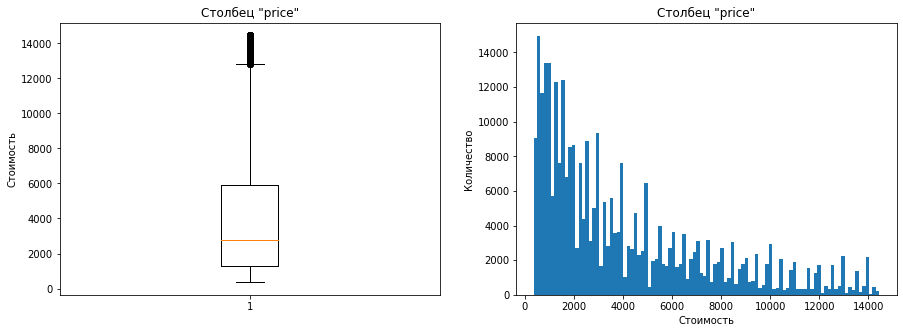

In [17]:
show_info('price', 'Стоимость')

### registration_year

In [18]:
df['registration_year'].value_counts()

2000    20898
2005    20755
1999    20617
2003    19200
2001    19083
        ...  
1948        1
1949        1
5300        1
8888        1
2290        1
Name: registration_year, Length: 130, dtype: int64

count    309117.000000
mean       2003.703792
std          65.648827
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: registration_year, dtype: float64

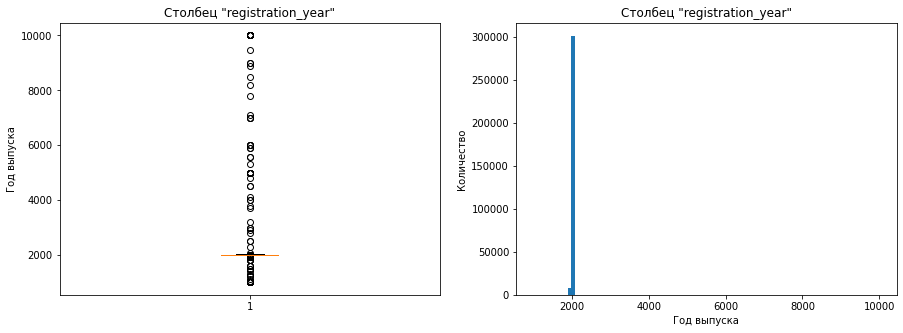

In [19]:
show_info('registration_year', 'Год выпуска')

В данном столбце так же наблюдаются выбросы. Для уточнения левой границы предварительно ограничимся 20м веком, т.е. 1900 годом. Для правой границы будем использовать данные о самом позднем скачивании анкеты автомобиля из столбца `DateCrawled`:

In [20]:
date_max = pd.to_datetime(df['date_crawled'])
date_max.max()

Timestamp('2016-04-07 14:36:58')

count    305372.000000
mean       2002.881505
std           6.919483
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2017.000000
Name: registration_year, dtype: float64

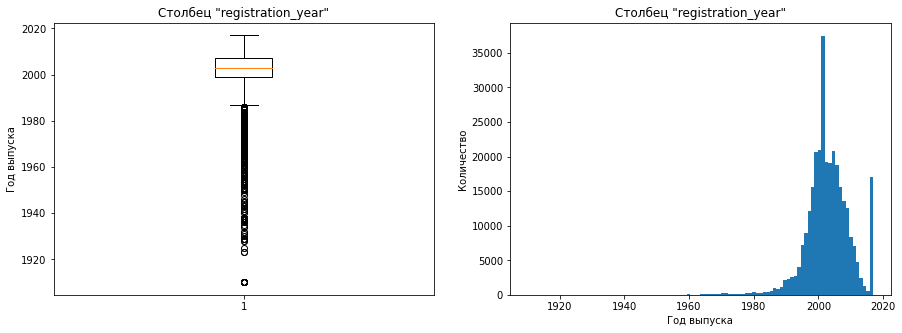

In [21]:
df = df.query('1900 <= registration_year <= 2017')
show_info('registration_year', 'Год выпуска')

Автомобиль считается раритетным, если с момента производства прошло 30 лет или больше. В нашем исследовании не будем столь категоричны и поднимем эту планку до 35 лет, т.о. левая граница наших данных будет проходить на 1982 году. Раритетные автомобили, даже если они и есть, необходимо исключить, т.к. у них иное ценообразование:

count    302254.000000
mean       2003.197708
std           6.135470
min        1982.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2017.000000
Name: registration_year, dtype: float64

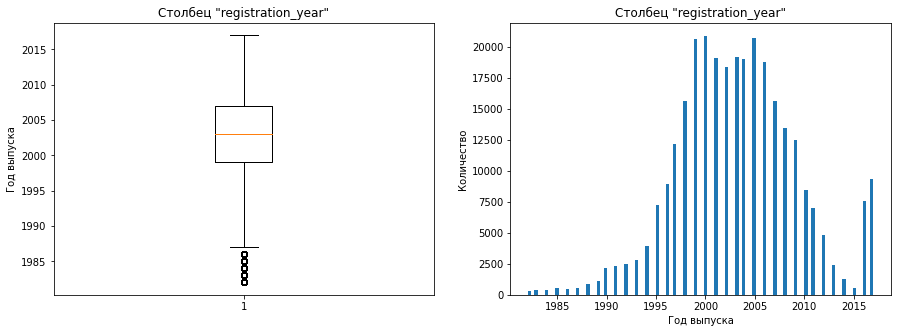

In [22]:
df = df.query('1982 <= registration_year')
show_info('registration_year', 'Год выпуска')

### gearbox

Выясним количество отсуствующих значений в процентах:

In [23]:
(df['gearbox'].isna().sum() / df.shape[0]) * 100

4.317229879505317

Отсутствует информация по типу коробки передач у 4,3% данных, удалим их, т.к. данная информация может сильно повлиять на нашу модель.

In [24]:
df.dropna(subset=['gearbox'], inplace=True)

Для упрощения категоризируем значения в столбце: механическая коробка - 1, автоматическая - 0:

In [25]:
df.loc[(df.gearbox == 'manual'), 'gearbox'] = 1
df.loc[(df.gearbox  == 'auto'), 'gearbox'] = 0

### repaired

In [26]:
df['repaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

In [27]:
(df['repaired'].isna().sum() / df.shape[0]) * 100

16.409467332860775

Т.к. количество отсутствующих значений в данном столбце велико, то заменим отсутствующие значения на заглушку *unknown*:

In [28]:
df['repaired'].fillna('unknown', inplace=True)

Также категоризируем данные в столбце:

In [29]:
df.loc[(df.repaired == 'yes'), 'repaired'] = 1
df.loc[(df.repaired == 'no'), 'repaired'] = 0
df.loc[(df.repaired == 'unknown'), 'repaired'] = 2

### model

In [30]:
(df['model'].isna().sum() / df.shape[0]) * 100

4.082225411040611

Модель автомобиля оказывает существенное влияние на цену, поэтому отсутвующие значения удалим:

In [31]:
df.dropna(subset=['model'], inplace=True)

### vehicle_type

In [32]:
(df['vehicle_type'].isna().sum() / df.shape[0]) * 100

6.0613051957649455

Заменим отсутствующие значение заглушкой *unknown*:

In [33]:
df['vehicle_type'].fillna('unknown', inplace=True)
df['vehicle_type'].value_counts()

sedan          76570
small          65987
wagon          55132
bus            24748
unknown        16814
convertible    15882
coupe          11778
suv             8285
other           2203
Name: vehicle_type, dtype: int64

### power

count    277399.000000
mean        113.553643
std         183.525764
min           0.000000
25%          75.000000
50%         105.000000
75%         141.000000
max       20000.000000
Name: power, dtype: float64

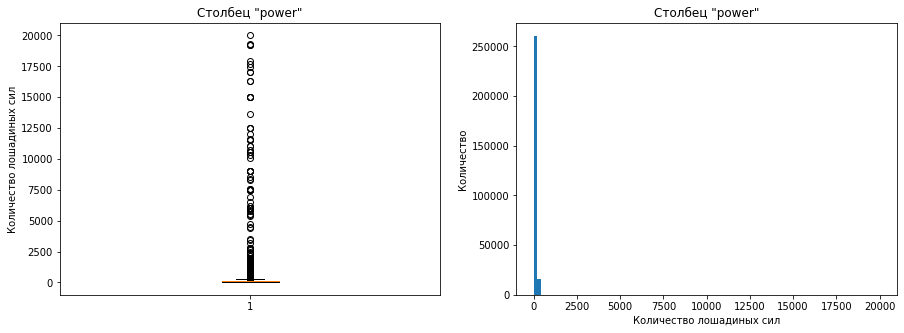

In [34]:
show_info('power', 'Количество лошадиных сил')

Левой границей мощности двигателя обозначим 9 л.с. (данной мощностью обладал автомобиль Citroën 2CV, который производился до 1990 года). Правой границей обозначим мощность в 400 л.с. (все автомобиле мощностью более 400 л.с. уже относятся к супер- или гиперкарам, а у них иное ценообразование):

count    258359.000000
mean        117.996764
std          49.120798
min           9.000000
25%          77.000000
50%         110.000000
75%         143.000000
max         400.000000
Name: power, dtype: float64

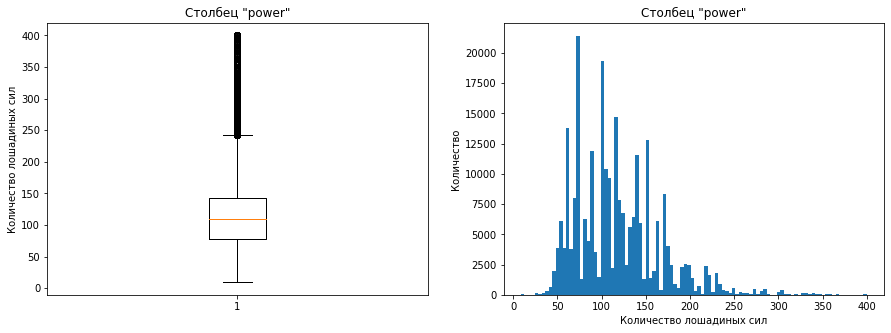

In [35]:
df = df.query('9 <= power <= 400')
show_info('power', 'Количество лошадиных сил')

### kilometer

In [36]:
df['kilometer'].value_counts()

150000    177252
125000     28095
100000     10822
90000       8645
80000       7384
70000       6168
60000       5266
50000       4230
40000       3219
30000       2715
20000       2125
5000        1913
10000        525
Name: kilometer, dtype: int64

Аномалии не выявлены, оставим без изменений.

### fuel_type

In [37]:
df['fuel_type'].value_counts()

petrol      164793
gasoline     76097
lpg           4277
cng            460
hybrid         141
other           55
electric        42
Name: fuel_type, dtype: int64

In [38]:
df['fuel_type'].isna().sum()

12494

Пропуски заполним значением *other*:

In [39]:
df['fuel_type'].fillna('other', inplace=True)
df['fuel_type'].value_counts()

petrol      164793
gasoline     76097
other        12549
lpg           4277
cng            460
hybrid         141
electric        42
Name: fuel_type, dtype: int64

### brand

In [40]:
df['brand'].value_counts()

volkswagen       56728
opel             29021
bmw              27612
mercedes_benz    23476
audi             21769
ford             18038
renault          12693
peugeot           8439
fiat              6790
seat              5393
skoda             4502
mazda             4303
citroen           3895
toyota            3748
smart             3702
nissan            3500
hyundai           2758
volvo             2480
mini              2422
mitsubishi        2211
honda             2193
kia               1844
suzuki            1774
alfa_romeo        1762
chevrolet         1244
chrysler          1046
dacia              774
subaru             548
daihatsu           538
jeep               470
saab               427
jaguar             354
daewoo             352
land_rover         336
lancia             325
porsche            309
rover              291
trabant            157
lada               135
Name: brand, dtype: int64

In [41]:
df['fuel_type'].isna().sum()

0

Отсутствующих значений нет.

### Общая подготовка данных

Изменим тип столбцов *gearbox* и *repaired*:

In [42]:
df[['gearbox', 'repaired']] = df[['gearbox', 'repaired']].astype(int)

Выделим признаки, необходимые для построения модели и создадим соответствующий датафрейм:

In [43]:
filtred_df = df[['vehicle_type',
                 'gearbox',
                 'power',
                 'kilometer',
                 'fuel_type',
                 'brand',
                 'repaired',
                 'registration_year',
                 'model',
                 'price']]
filtred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258359 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       258359 non-null  object
 1   gearbox            258359 non-null  int64 
 2   power              258359 non-null  int64 
 3   kilometer          258359 non-null  int64 
 4   fuel_type          258359 non-null  object
 5   brand              258359 non-null  object
 6   repaired           258359 non-null  int64 
 7   registration_year  258359 non-null  int64 
 8   model              258359 non-null  object
 9   price              258359 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 21.7+ MB


Проверим на дубликаты:

In [44]:
filtred_df.duplicated().sum()

36360

Удалим дубликаты:

In [45]:
filtred_df = filtred_df.drop_duplicates().reset_index(drop=True)
filtred_df.duplicated().sum()

0

In [46]:
filtred_df.sample(5)

,vehicle_type,gearbox,power,kilometer,fuel_type,brand,repaired,registration_year,model,price
17898,unknown,1,101,60000,petrol,opel,0,1995,astra,4000
143855,small,1,75,150000,petrol,volkswagen,0,1995,polo,550
218487,small,1,95,150000,petrol,smart,0,2004,forfour,1999
62293,small,1,60,125000,petrol,fiat,0,2009,panda,2490
136828,convertible,1,101,150000,petrol,volkswagen,1,1994,golf,999


In [47]:
filtred_df.corr()

,gearbox,power,kilometer,repaired,registration_year,price
gearbox,1.000000,-0.397769,-0.051203,0.021011,0.011274,-0.186202
power,-0.397769,1.000000,0.190222,-0.050551,0.032531,0.435721
kilometer,-0.051203,0.190222,1.000000,0.093887,-0.302297,-0.330832
repaired,0.021011,-0.050551,0.093887,1.000000,-0.065117,-0.211032
registration_year,0.011274,0.032531,-0.302297,-0.065117,1.000000,0.499886
price,-0.186202,0.435721,-0.330832,-0.211032,0.499886,1.000000


In [48]:
phik_m = filtred_df.phik_matrix(interval_cols=['gearbox', 'power', 'kilometer', 'repaired', 'registration_year', 'price'])
phik_m

,vehicle_type,gearbox,power,kilometer,fuel_type,brand,repaired,registration_year,model,price
vehicle_type,1.000000,0.192100,0.477475,0.302136,0.404704,0.599097,0.309322,0.564244,0.899795,0.218112
gearbox,0.192100,1.000000,0.546956,0.060941,0.122760,0.489931,0.012802,0.101298,0.631044,0.240709
power,0.477475,0.546956,1.000000,0.184828,0.249763,0.568381,0.065696,0.259045,0.803098,0.436047
kilometer,0.302136,0.060941,0.184828,1.000000,0.195371,0.299529,0.207583,0.400021,0.470687,0.275215
fuel_type,0.404704,0.122760,0.249763,0.195371,1.000000,0.264267,0.156415,0.331016,0.499497,0.234624
brand,0.599097,0.489931,0.568381,0.299529,0.264267,1.000000,0.117896,0.343568,0.998545,0.303850
repaired,0.309322,0.012802,0.065696,0.207583,0.156415,0.117896,1.000000,0.242647,0.194297,0.310133
registration_year,0.564244,0.101298,0.259045,0.400021,0.331016,0.343568,0.242647,1.000000,0.632134,0.665199
model,0.899795,0.631044,0.803098,0.470687,0.499497,0.998545,0.194297,0.632134,1.000000,0.539551
price,0.218112,0.240709,0.436047,0.275215,0.234624,0.303850,0.310133,0.665199,0.539551,1.000000


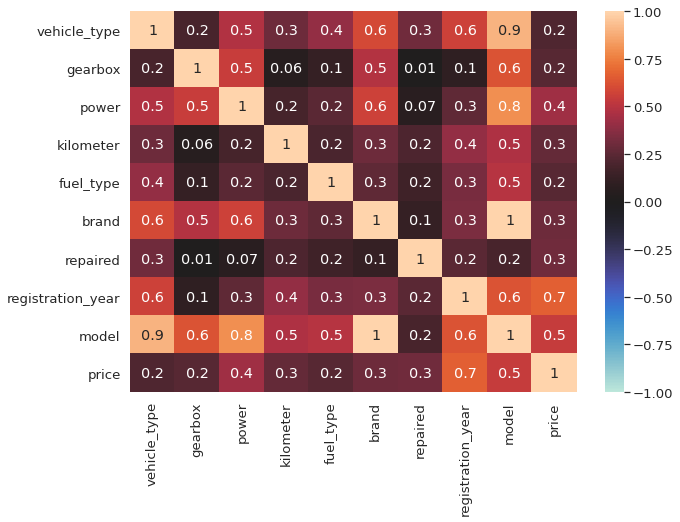

In [49]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(phik_m, annot= True, vmin=-1, vmax=1, center= 0, fmt='.1g')

plt.show()

Цена на автомобиль коррелирует с годом регистрации и мощностью двигателя и обратно коррелирует пройденому километражу.

**Вывод:**

- изучили данные;
- отобрали необходимые признаки для построения модели;
- удалили аномальные значения и значения, которые не представляется возможность восстановить и могут оказать влияние на построение модели;
- где представлялось возможным заменили отсутствующие значения;
- заменили два категориальных признака на численные;
- удалили дубликаты;
- выяснили возможные корреляции признаков.

## Обучение моделей

Выберем следующие модели для обучения:

- LinearRegression;
- DecisionTreeRegressor;
- CatBoostRegressor;
- LGBMRegressor.

В качестве метрики для всех моделей будем использовать RMSE. При подборе гиперпараметров будем использовать кроссвалидацию.

Для построения моделей будем использовать 3 типа признаков:

- неизмененные: features;
- закодированные методом OHE: ohe_features;
- закодированные методом OE: ordinal_features.

Разделим данные на обучающую, валидационную и тестовую выборки:

In [50]:
features = filtred_df.drop('price', axis=1)
target = filtred_df['price']

In [51]:
features_train, features_v, target_train, target_v = train_test_split(
    features, target, test_size=0.4, random_state=15243)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_v, target_v, test_size=0.5, random_state=15243)

Кодирование:

In [52]:
cat_columns = features_train.select_dtypes(include='object').columns.to_list()

encoder_OE = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder_OE.fit(features_train[cat_columns])

encoder_OHE = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder_OHE.fit(features_train[cat_columns])

OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)

In [53]:
def encod_OE(encod, df):
    cat_features = pd.DataFrame(encod.transform(df[cat_columns]),
                                columns=df[cat_columns].columns,
                                index=df[cat_columns].index)
    encod_df = df.copy()
    
    for column in cat_columns:
        encod_df[column] = cat_features[column]
        
    return encod_df

In [54]:
def encod_OHE(encod, df):
    encod_df = df.copy()
    try:
        encod_df[encod.get_feature_names_out()] = encod.transform(df[cat_columns])
    except:
        encod_df[encod.get_feature_names()] = encod.transform(df[cat_columns])
    encod_df = encod_df.drop(cat_columns, axis=1)
    
    return encod_df

In [55]:
ordinal_features_train = encod_OE(encoder_OE, features_train)
ordinal_features_valid = encod_OE(encoder_OE, features_valid)
ordinal_features_test = encod_OE(encoder_OE, features_test)

In [56]:
ohe_features_train = encod_OHE(encoder_OHE, features_train)
ohe_features_valid = encod_OHE(encoder_OHE, features_valid)
ohe_features_test = encod_OHE(encoder_OHE, features_test)

Для подбора гиперпараметров и построения моделей напишем соответствующие функции:

In [57]:
def best_param(model, f_train, t_train, params):
    start = time.time()

    grid = GridSearchCV(model, params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(f_train, t_train)
    end = time.time()

    b_time = end - start

    return grid.best_params_, b_time

In [73]:
def calculation(model, f_train, t_train, f_val, t_val, params, flag=False):
    model_type = {
        'lr': LinearRegression,
        'dtr': DecisionTreeRegressor,
        'cbr': CatBoostRegressor,
        'lgbrm': LGBMRegressor
    }
    
    if flag:
        best_par = params
        par_time = 0
    else:
        best_par, par_time = best_param(model_type[model](), f_train, t_train, params)
    start = time.time()
    best_model = model_type[model](**best_par)
    best_model.fit(f_train, t_train)
    end = time.time()
    model_time = end - start
    
    start = time.time()
    pred_target = best_model.predict(f_val)
    end = time.time()
    pred_time = end - start
    
    rmse = mean_squared_error(t_val, pred_target) ** .5
    
    table = PrettyTable()
    table.field_names = ['Данные', 'Значение']
    table.add_row(['Подбор параметров', f'{par_time // 60} мин {(par_time % 60):.2f} сек'])
    table.add_row(['Обучение модели', f'{model_time:.2f} сек'])
    table.add_row(['Предсказание модели', f'{pred_time:.2f} сек'])
    table.add_row(['RMSE', f'{rmse}'])
    table.add_row([' ', ' '])
    table.add_row(['Лучшие параметры:', ' '])
    for k, v in best_par.items():
        table.add_row([f'{k}:', v])
    print(table)
    
    
    return best_model, rmse, model_time, pred_time

In [59]:
STATE = np.random.RandomState(15243)

### LinearRegression

In [60]:
%%time

params = {'fit_intercept': [True, False], 'positive': [True, False]}
lr_model, lr_model_rmse, lr_model_time, lr_pred_time = calculation('lr',
                                                                   ohe_features_train,
                                                                   target_train,
                                                                   ohe_features_valid,
                                                                   target_valid,
                                                                   params)

+---------------------+--------------------+
|      Показатель     |      Значение      |
+---------------------+--------------------+
|  Подбор параметров  | 4.0 мин 55.08 сек  |
|   Обучение модели   |     15.80 сек      |
| Предсказание модели |      0.20 сек      |
|         RMSE        | 1956.2969900580738 |
|                     |                    |
|  Лучшие параметры:  |                    |
|    fit_intercept:   |        True        |
|      positive:      |       False        |
+---------------------+--------------------+
CPU times: user 4min 26s, sys: 43.4 s, total: 5min 9s
Wall time: 5min 11s


### DecisionTreeRegressor

#### кодировка OHE

In [61]:
%%time

params = {'max_depth':[x for x in range(2, 31)],
          'random_state':[STATE]}
dtr_model_OHE, dtr_model_rmse_OHE, dtr_model_time_OHE, dtr_pred_time_OHE = calculation('dtr',
                                                                                       ohe_features_train,
                                                                                       target_train,
                                                                                       ohe_features_valid,
                                                                                       target_valid,
                                                                                       params)

+---------------------+----------------------+
|      Показатель     |       Значение       |
+---------------------+----------------------+
|  Подбор параметров  |  5.0 мин 28.16 сек   |
|   Обучение модели   |       2.92 сек       |
| Предсказание модели |       0.08 сек       |
|         RMSE        |  1548.901033155775   |
|                     |                      |
|  Лучшие параметры:  |                      |
|      max_depth:     |          15          |
|    random_state:    | RandomState(MT19937) |
+---------------------+----------------------+
CPU times: user 5min, sys: 30.1 s, total: 5min 30s
Wall time: 5min 31s


#### кодировка OE

In [62]:
%%time

params = {'max_depth':[x for x in range(2, 31)],
          'random_state':[STATE]}
dtr_model_OE, dtr_model_rmse_OE, dtr_model_time_OE, dtr_pred_time_OE = calculation('dtr',
                                                                                   ordinal_features_train,
                                                                                   target_train,
                                                                                   ordinal_features_valid,
                                                                                   target_valid,
                                                                                   params)

+---------------------+----------------------+
|      Показатель     |       Значение       |
+---------------------+----------------------+
|  Подбор параметров  |  0.0 мин 43.53 сек   |
|   Обучение модели   |       0.32 сек       |
| Предсказание модели |       0.01 сек       |
|         RMSE        |  1556.1896929816853  |
|                     |                      |
|  Лучшие параметры:  |                      |
|      max_depth:     |          13          |
|    random_state:    | RandomState(MT19937) |
+---------------------+----------------------+
CPU times: user 43.6 s, sys: 253 ms, total: 43.8 s
Wall time: 43.9 s


### CatBoostRegressor

Для CatBoostRegressor будем использовать только кодировку ОЕ:

In [68]:
%%time

params = {'learning_rate':[0.1, 0.5, 0.8],
          'verbose':[False],
          'random_state':[15243]}
cbr_model_OE, cbr_model_rmse_OE, cbr_model_time_OE, cbr_pred_time_OE = calculation('cbr',
                                                                                   ordinal_features_train,
                                                                                   target_train,
                                                                                   ordinal_features_valid,
                                                                                   target_valid,
                                                                                   params)

+---------------------+--------------------+
|      Показатель     |      Значение      |
+---------------------+--------------------+
|  Подбор параметров  |  4.0 мин 6.02 сек  |
|   Обучение модели   |     19.14 сек      |
| Предсказание модели |      0.04 сек      |
|         RMSE        | 1294.3057053038358 |
|                     |                    |
|  Лучшие параметры:  |                    |
|    learning_rate:   |        0.5         |
|    random_state:    |       15243        |
|       verbose:      |       False        |
+---------------------+--------------------+
CPU times: user 4min 5s, sys: 0 ns, total: 4min 5s
Wall time: 4min 25s


In [69]:
%%time

params = {'learning_rate':0.1,
          'random_state':15243,
          'cat_features':['vehicle_type','fuel_type','brand','model']}
cbr_model, cbr_model_rmse, cbr_model_time, cbr_pred_time = calculation('cbr',
                                                                       features_train,
                                                                       target_train,
                                                                       features_valid,
                                                                       target_valid,
                                                                       params,
                                                                       flag=True)

0:	learn: 3304.3270409	total: 131ms	remaining: 2m 10s
1:	learn: 3113.4733688	total: 271ms	remaining: 2m 15s
2:	learn: 2938.2940372	total: 387ms	remaining: 2m 8s
3:	learn: 2785.3425456	total: 463ms	remaining: 1m 55s
4:	learn: 2651.5441894	total: 604ms	remaining: 2m
5:	learn: 2535.5664821	total: 708ms	remaining: 1m 57s
6:	learn: 2430.4572455	total: 833ms	remaining: 1m 58s
7:	learn: 2339.7250155	total: 927ms	remaining: 1m 55s
8:	learn: 2255.5653046	total: 1.07s	remaining: 1m 57s
9:	learn: 2180.8571573	total: 1.19s	remaining: 1m 57s
10:	learn: 2120.5339820	total: 1.27s	remaining: 1m 54s
11:	learn: 2063.6970491	total: 1.41s	remaining: 1m 55s
12:	learn: 2004.2690526	total: 1.54s	remaining: 1m 57s
13:	learn: 1954.9863665	total: 1.66s	remaining: 1m 56s
14:	learn: 1913.1620199	total: 1.78s	remaining: 1m 56s
15:	learn: 1876.8929168	total: 1.91s	remaining: 1m 57s
16:	learn: 1845.6317076	total: 2.02s	remaining: 1m 56s
17:	learn: 1812.1803430	total: 2.15s	remaining: 1m 57s
18:	learn: 1780.4528338	t

### LGBMRegressor

In [65]:
%%time

params = {'num_leaves':[31, 100, 200],
          'learning_rate':[0.1, 0.3, 0.5],
          'num_threads':[10],
          'force_row_wise':[True],
          'random_state':[STATE]}
lgbrm_model_OE, lgbrm_model_rmse_OE, lgbrm_model_time_OE, lgbrm_pred_time_OE = calculation('lgbrm',
                                                                                           ordinal_features_train,
                                                                                           target_train,
                                                                                           ordinal_features_valid,
                                                                                           target_valid,
                                                                                           params)

[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_t

**Вывод:** Построены 4 модели с разными типами данных. Лучшие результаты RMSE и времени обучения/предсказания моделей сохранены.

## Анализ моделей

Создадим таблицу для сравнения результатов:

In [70]:
data = {'RMSE_обучения':[lr_model_rmse,
                         dtr_model_rmse_OHE,
                         dtr_model_rmse_OE,
                         cbr_model_rmse_OE,
                         cbr_model_rmse,
                         lgbrm_model_rmse_OE],
   
        'Время обучения модели, сек.':[lr_model_time, dtr_model_time_OHE, dtr_model_time_OE, 
                                       cbr_model_time_OE, cbr_model_time, lgbrm_model_time_OE],
        
        'Время предсказания модели, сек.':[lr_pred_time ,dtr_pred_time_OHE, dtr_pred_time_OE, 
                                           cbr_pred_time_OE, cbr_pred_time, lgbrm_pred_time_OE]
       }
index = ['LinearRegression',
         'DecisionTreeRegressor OHE',
         'DecisionTreeRegressor OE',
         'CatBoostRegressor OE',
         'CatBoostRegressor',
         'LGBMRegressor']


data_rmse = pd.DataFrame(data=data, index=index)
data_rmse

,RMSE_обучения,"Время обучения модели, сек.","Время предсказания модели, сек."
LinearRegression,1956.296990,15.798489,0.199368
DecisionTreeRegressor OHE,1548.901033,2.922793,0.079787
DecisionTreeRegressor OE,1556.189693,0.319885,0.010317
CatBoostRegressor OHE,1294.305705,19.143769,0.044096
CatBoostRegressor,1304.257368,97.656687,0.308976
LGBMRegressor,1296.489180,27.002106,0.497827


Проверим модель DecisionTreeRegressor OE на тестовой выборке: 

In [71]:
%%time

target_pred_test = dtr_model_OE.predict(ordinal_features_test)

CPU times: user 10.1 ms, sys: 0 ns, total: 10.1 ms
Wall time: 9.4 ms


In [72]:
mean_squared_error(target_test, target_pred_test) ** .5

1581.3176197575706

Скорость предсказания на тестовой выборке **0.009 сек** с RMSE **1581.3176197575706**

## Общий вывод

- загрузили данные и провели предобработку;
- выполнили сравнение различных моделей с подбором гиперпараметров;
- выбрали лучшую модель по результатам метрики RMSE и времени обучения.

Для определения лучшей модели заказчиком были обозначены следующие критерии:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

В ходе оценки не учитывалось время обучения модели на кроссвалидации. Все модели выполнили условие RMSE < 2500.

Сумарно по трем критериям лучшей моделью является *DecisionTreeRegressor OE* (признаки были закодированы OrdinalEncoder). С точки зрения метрики RMSE она проигрывает лидеру CatBoostRegressor OE (1556.189693 против 1294.305705), но по остальным критериям данная модель обходит другие модели в десять раз.

В качестве альтернативы, если критерий качества предсказания является преобладающий, можно использовать модели *CatBoostRegressor OE* и *LGBMRegressor*: у них лучший результат метрики RMSE (1294.305705 и 1296.489180 соответственно), но у них высокое время обучения модели и время предсказания по сравнению с *DecisionTreeRegressor OE*.